# Main Code to compile a trajectory    
- By Ehsan Erfani   @UW, 2022   
- Original Python code by Johannes Mohrmann  @UW, summer 2020  
    
    
- Summary of Modifications by Ehsan: 
  - Changes in parameters and functions to facilitate automation and to generalize the code for projects other than CSET (for automation, a separate python code is provided)
  - Addition of optional part 2 (visualization and verification)
    
    
- Note by Ehsan: Some names of functions or variables in this code or other codes of the package might refer to "CSET", but most should work for any other project. 

In [1]:
### Importing required libraries
import datetime as dt
import numpy as np
import os
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import pandas as pd
from itertools import cycle
from geographiclib.geodesic import Geodesic
import time
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from pandas import Series, DataFrame
from netCDF4 import Dataset
from math import log10
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")


from MERRA2.add_to_trajectory import add_MERRA_to_trajectory
from ERA5.add_to_trajectory import add_ERA_ens_to_trajectory, \
     add_ERA_sfc_to_trajectory, add_ERA_to_trajectory, add_advection_to_trajectory
from AMSR_Tb.add_to_trajectory import add_AMSR_Tb_to_trajectory
from CERES.add_to_trajectory import add_CERES_to_trajectory
from MODIS_pbl.add_to_trajectory import add_MODIS_pbl_to_trajectory
from SSMI.add_to_trajectory import add_SSMI_to_trajectory
from AMSR.add_to_trajectory import add_AMSR_to_trajectory

import utils
import config
import met_utils
import les_utils

In [2]:
##### Parameters:
all_datasets = ['ERA', 'ERA_sfc', 'ERA_ens', 'MERRA', 'CERES', 'SSMI', 'AMSR', 'AMSR_Tb', 'MODIS_pbl']
skip1        = ['ERA_ens']  ## Which of the above datasets should be skipped?
traj_dirc    = ['forward']  ## trajectory direction, options: 'forward', 'backward'
AUTHORS      = ['Ehsan Erfani (Ehsan@nevada.unr.edu); Rob Wood (robwood2@uw.edu)']

## Parameters for 1-time runs:
YYYY = ['2018']  # ['2019', '2020', '2021']
MM   = ['06']    # ['07', '08']
DD   = [1]      

traj_locs     = ['01']  # ['02', '03', '04', '05', '06'] 
traj_loc_longs= ['(37.7 N, 131.4 W): A location towards the northern edge of the NEP Sc deck', \
                 '(35.0 N, 125.0 W): GPCI-S12 location in Lewis (2016)', \
                 '(32.0 N, 129.0 W): GPCI-S11 location in Lewis (2016)', \
                 '(29.0 N, 133.0 W): GPCI-S10 location in Lewis (2016)', \
                 '(26.0 N, 137.0 W): GPCI-S09 location in Lewis (2016)', \
                 '(25.0 N, 125.0 W): NEP location in Sandu et al. (2010)']

# start_dates   = '201806010900' # '201904231900' # start date of trajectory set in the code "unified_traj_data", format: YYYYMMDDHHMM

## Main part: Create the Trajectory:
### Required functions

In [3]:
def rounder(values):
    def f(x):
        idx = np.argmin(np.abs(values - x))
        return values[idx]
    return np.frompyfunc(f, 1, 1)    

def xarray_from_cset_flight_trajectory(rfnum, trajnum, trajectory_type='500m_+72'):
    tdump = utils.load_flight_trajectory(traj_loc, start_dates, rfnum, trajnum, trajectory_type=trajectory_type)
    ds = xarray_from_tdump(tdump)
    global_attrs = [{'flight': rfnum},
        {'trajectory': str(trajnum)}]
    for i in global_attrs:  # note: an OrderedDict would be tidier, but does not unpack in order
        ds = ds.assign_attrs(**i)
    return ds
    
def xarray_from_tdumpfile(tdumpfile):
    tdump = utils.read_tdump(tdumpfile).sort_values('dtime')
    ds = xarray_from_tdump(tdump)
    return ds
    

def xarray_from_tdump(tdump):
    ds = xr.Dataset.from_dataframe(tdump).drop(['tnum', 'gnum', 'age'])
    ds = ds.rename({'dtime': 'time'})
    # assigning global attributes
    global_attrs = [
        {'Title': "Unified Trajectory Product"},
        {'institution': "Department of Atmospheric Sciences, University of Washington"},
        {'Authors': AUTHORS},
        {'Creation_Time': str(dt.datetime.utcnow())},
        {'Start_Time_of_Trajectory': start_dates},
        {'Start_Location_of_Trajectory': traj_loc_long},
        {'trajectory_setup': "Trajectories were run isobarically " +
                            "from an initialization height of 500m " +
                            "for 72 hours, using ECMWF ERA5 reanalysis met data"},
        {'Trajectory_model_params': "The trajectories were produced by Ryan Eastman @ UW by using ECMWF ERA5 "+
                   "Lagrangian Trajectory Model using horizontal winds at 950 hPa (within the PBL). "},
        {'Trajectory_model_reference': "Eastman, R., & Wood, R. (2016). Factors controlling low-cloud "+
                      "evolution over the eastern subtropical oceans: A Lagrangian perspective using "+
                      "the A-Train satellites. Journal of Atmospheric Sciences, 73(1), 331-351. "+ 
                      "https://doi.org/10.1175/JAS-D-15-0193.1"}]
    for i in global_attrs:  # note: an OrderedDict would be tidier, but does not unpack in order
        ds = ds.assign_attrs(**i)
    
    # assigning variable attributes
    var_attrs = {
        'lon': {'long_name': 'longitude', 
                'units': 'degrees N'},
        'lat': {'long_name': 'latitude',
                'units': 'degrees E'},
        'fhour': {'long_name': 'forecast_lead_time',
                  'units': 'hours'},
        'pres': {'long_name':'trajectory_pressure',
                 'units': 'hPa'},
        'height': {'long_name': 'trajectory_height_above_ground',
                  'units': 'meters'}}
    for k,v in var_attrs.items():
        ds[k] = ds[k].assign_attrs(**v)
    ds.time.attrs['long_name'] = 'time'
    return ds

def save_trajectory_to_netcdf(ds, location):
    ds.to_netcdf(location)

def add_speeds_to_trajectories(ds):
    """Add speed variables to trajectory. used centered difference of distances traveled
    """
    lats, lons, times = ds.lat.values, ds.lon.values, ds.time.values
    
    heading_starts, heading_ends, seg_speeds = [], [], []
    
    for i in range(len(lats)-1):
        geod = Geodesic.WGS84.Inverse(lats[i], lons[i], lats[i+1], lons[i+1])
        dtime = (times[i+1]-times[i])/np.timedelta64(1, 's')
        heading_starts.append(geod['azi1'])
        heading_ends.append(geod['azi2'])
        seg_speeds.append(geod['s12']/dtime)

    #speeds are centered difference, except at start and end, where they are speeds of 
    #first and last trajectory segments
    #headings are average of end azimuth of previous segment/start azimuth of next geodesic segment,
    #except at start and end, where are just the start/end azimuths of the first/last geodesic
    speeds = np.mean(np.vstack([seg_speeds+[seg_speeds[-1]],[seg_speeds[0]]+seg_speeds]), axis=0)
     #headings = np.mean(np.vstack([[heading_starts[0]]+heading_ends, heading_starts+[heading_ends[-1]]]), axis=0) THIS HAD A BUG
    def radial_mean(h1, h2):
        diff = ((h2-h1)+180)%360-180
        return h1 + diff/2
    headings = radial_mean(np.array([heading_starts[0]]+heading_ends), np.array(heading_starts+[heading_ends[-1]]))
    
    u = speeds*np.cos(np.deg2rad(90-headings))
    v = speeds*np.sin(np.deg2rad(90-headings))
    
    ds['traj_u'] = (('time'), u, {'long_name': 'U component of trajectory velocity', 'units': "m s**-1"})
    ds['traj_v'] = (('time'), v, {'long_name': 'V component of trajectory velocity', 'units': "m s**-1"})
    ds['traj_hdg'] = (('time'), headings, {'long_name': 'Trajectory heading', 'units': 'deg'})
    ds['traj_spd'] = (('time'), speeds, {'long_name': 'Trajectory speed', 'units': "m s**-1"})
    return ds   



def make_trajectory(ds, skip=skip1, save=False):
    ds = add_speeds_to_trajectories(ds)        
    if not 'ERA' in skip:
        print("adding ERA...")
        ds = add_ERA_to_trajectory(ds)
        print('adding advection...')
        ds = add_advection_to_trajectory(ds)
    if not 'ERA_sfc' in skip:
        print('adding ERA sfc data...')
        ds = add_ERA_sfc_to_trajectory(ds)
    if not 'ERA_ens' in skip:
        print('adding ERA ensemble data...')
        ds = add_ERA_ens_to_trajectory(ds)        
    if not 'MERRA' in skip:
        print("adding MERRA...")
        ds = add_MERRA_to_trajectory(ds)        
    if not 'CERES' in skip:
        print("adding CERES...")
        ds = add_CERES_to_trajectory(ds)        
    if not 'SSMI' in skip:
        print("adding SSMI...")
        ds = add_SSMI_to_trajectory(ds)
    if not 'AMSR' in skip:
        print("adding AMSR2...")
        ds = add_AMSR_to_trajectory(ds)
    if not 'AMSR_Tb' in skip:
        print("adding AMSR Tb...")
        ds = add_AMSR_Tb_to_trajectory(ds)
    if not 'MODIS_pbl' in skip:
        print("adding MODIS...")
        ds = add_MODIS_pbl_to_trajectory(ds)
    if save:
        save_trajectory_to_netcdf(ds, save)
    return ds

## This function is significantly changed by Ehsan Erfani and is now generalized for future trajectories
def make_CSET_trajectory(rfnum, trajnum, save=False, trajectory_type='500m_+72', skip=skip1):
    ds = xarray_from_cset_flight_trajectory(rfnum, trajnum, trajectory_type)
    ds = make_trajectory(ds, skip=skip, save=save)
    return ds

### Run the code for one single trajectory

In [4]:
if __name__ == "__main__":

    for y1 in YYYY:
        for jjj, m1 in enumerate(MM):
            for d1 in DD: # range(1,DD[jjj]+1):
                for iii in range(len(traj_locs)):
                    
                    start_dates   = y1 + m1 + f"{d1:02d}" + '0900' # start date of trajectory set in the code "unified_traj_data", format: YYYYMMDDHHMM
                    traj_loc      = traj_locs[iii]
                    traj_loc_long = traj_loc_longs[iii]

                    force_override = True
                    for case_num, case in config.all_cases.items():
                #         print('working on case {}'.format(case_num))
                        flight = case['TLC_name'].split("_")[0][:4].lower()
                        traj_list = case['TLC_name'].split('_')[1].split('-')

                        for dirn in traj_dirc:
                            nc_dirstring = '48h_backward' if dirn == 'backward' else '72h_forward'
                            for traj in traj_list:
                #                 name = os.path.join(config.trajectory_netcdf_dir, "{}_{}_{}.nc".format(flight, nc_dirstring, traj))
                                name = os.path.join(config.trajectory_netcdf_dir, "st_{}_{}_{}.nc"\
                                                    .format(nc_dirstring, traj_loc, start_dates[:-4]))
                                print("working on {}...".format(os.path.basename(name)))
                #                 if os.path.exists(name):
                #                     print("already exists!")
                #                     if not force_override:
                #                         continue
                #                     else:
                #                         print('overriding')
                #                         os.rename(name, os.path.join(config.trajectory_netcdf_dir, 'old', "sr_{}_{}.nc".format(nc_dirstring, start_dates[:-4])))
                                trajectory_type = '500m_-48' if dirn == 'backward' else '500m_+72'
                #                 print(name)
                                ds = make_CSET_trajectory(rfnum=flight, trajnum=float(traj), save=name, \
                                                          trajectory_type=trajectory_type, skip=skip1);


working on st_72h_forward_01_20180601.nc...
adding ERA...
100.00%      ETA 10:38:44      time left: 0 seconds                                                                                                                                                                   adding advection...
adding ERA sfc data...
adding MERRA...
0.0212
0.13686516019711023
0.0118
0.049871942657269304
0.0695
0.3127082994315797
adding CERES...
adding SSMI...
adding AMSR2...
adding AMSR Tb...
adding MODIS...


## Optional: Visualization and Verification

In [5]:
def traj_postprocess(camp='NEP', dn='./', date='20180601', HH='09', t_strt='09', del_t=48, traj_dirc=['forward'], t_flight=[0.79, 1.79], Obs_jump=19):

    # date
    my_date = dt.datetime.strptime(date,'%Y%m%d')
    YYYY = str(my_date.year)
    MM   = f"{my_date.month:02d}"
    DD   = f"{my_date.day:02d}"

    idx_strt = int(t_strt) - int(HH)

    ##### read trajectory files
    MERRA_data = Dataset('/home/disk/eos3/erfani/Data/'+camp+'/Lagrangian_project/'+dn+'st' + '_72h_forward_' + traj_loc + '_' + date + '.nc')
    if traj_dirc == ['forward', 'backward']:
        MERRA_datab = Dataset('/home/disk/eos3/erfani/Data/'+camp+'/Lagrangian_project/'+dn+'st' + '_48h_backward_' + traj_loc + '_' + date + '.nc')

    #### Parameters
    ylim      = 4000
    init_time = YYYY + '-' + MM + '-' + DD + ' ' + t_strt + 'Z'

    zen_cut = 75 # do not consider CERES/GOES variables, when zenith angle is greater than cut-off

    start_row = 0  # drop headers of trajectory data


    ###############################################################
    ### Calculate inversion height (min of dtheta/dz * dRH/dz)

    ## find delta after calculating mid-point values
    def delta(THETA):
        nz = THETA.shape[1]
        THETAi = np.arange(THETA.shape[0] * (nz+1)).reshape(THETA.shape[0], nz+1).astype(float)
        THETAi[:] = np.nan
        THETAi[:,0] = 0
        THETAi[:,1:nz] = 0.5 * (THETA[:,:nz-1] + THETA[:,1:nz])
        THETAi[:,nz] = 1.5 * THETA[:,nz-1] - 0.5 * THETA[:,nz-2]
        d_THETA = THETAi[:,1:] - THETAi[:,:-1]
        return d_THETA

    def inv_h(THETA, RH, dzz, zz):        
        d_THETA = THETA[:,1:] - THETA[:,:-1]
        d_RH = RH[:,1:] - RH[:,:-1]

        ZINV = d_THETA[:,0].copy()
        ZINV[:] = np.nan
        for i in range(d_THETA.shape[0]):
            z  = zz[i,:]  if len(zz.shape) > 1 else zz
            dz = dzz[i,:] if len(zz.shape) > 1 else dzz
            dTHETA_dz = d_THETA[i,:] / dz[1:]
            dRH_dz = d_RH[i,:] / dz[1:]
            dTHETA_dz[dTHETA_dz < 0] = 0
            dRH_dz[dRH_dz > 0] = 0    
            func = dTHETA_dz * dRH_dz
            if len(zz.shape) > 1:
                indx = np.max(np.where(func == np.nanmin(func))[0])
            else:
                indx = np.min(np.where(func == np.nanmin(func))[0])                    
            # approximate func as a parabola around the minimum and find the height where that parabola is minimized. 
            # This will allow the inversion height to vary continuously as the input profiles change.
            # inversion_test is defined at midpoints of grid
            zavg = 0.5 * (z[:-1] + z[1:])
            rnge = range(indx-1, indx+2)
            # we define the parabola, converting from m to km.
            pp = np.polyfit(1e-3 * zavg[rnge], func[rnge], 2)
            # take the derivative of the parabola in coeffient space.
            pp_prime = np.array([2 * pp[0], pp[1]]) # this is its derivative
            # find the zero-crossing of the derivative. This is the inversion height in meters
            z_inv = -1e3 * pp_prime[1] / pp_prime[0]         
            ZINV[i] = z_inv
        return ZINV

    def mbl_ave_MERRA(MERRA_Na, ERA_ZINV, dz_MERRA):
        MERRA_Na_mean2 = MERRA_Na[:,0].copy()
        MERRA_Na_mean2[:] = np.nan
        for i in range(MERRA_Na_mean2.size):
            jjj = np.where(abs(MERRA_H[i,:] - ERA_ZINV[i]) == np.nanmin(abs(MERRA_H[i,:] - ERA_ZINV[i])))[0][0]
            MERRA_Na_mean2[i] = np.nansum(MERRA_RHO[i,jjj:] * MERRA_Na[i,jjj:] * dz_MERRA[i,jjj-1:])\
            / np.nansum(MERRA_RHO[i,jjj:] * dz_MERRA[i,jjj-1:])
        return MERRA_Na_mean2

    ## Find the index of model time when aircraft passes
    def model_index(time, t_flight):
        iii = np.where(abs(time - t_flight) == np.nanmin(abs(time - t_flight)))[0][0]
        return iii


    ##############################################################################
    ### Read various satellite and reanalysis variables from trajectory files

    ## Concatenate a variable from forward and backward trajectories
    def read_var_1D(var_name):
        if traj_dirc == ['forward', 'backward']:
            var = np.concatenate( ( MERRA_datab.variables[var_name][(-Obs_jump+1):], \
                                  MERRA_data.variables[var_name][:del_t]), axis=0)
        else:
            var = MERRA_data.variables[var_name][idx_strt:del_t+idx_strt]
        return var

    def read_var_2D(var_name):
        if traj_dirc == ['forward', 'backward']:
            var = np.concatenate( ( MERRA_datab.variables[var_name][(-Obs_jump+1):,:], \
                                  MERRA_data.variables[var_name][:del_t]), axis=0)
        else:
            var = MERRA_data.variables[var_name][idx_strt:del_t+idx_strt,:]
        return var



    ### CERES
    CERES_zenith  = read_var_1D('CERES_solar_zen_angle_1h')   # Cloud Top Height - Low clouds    
    cut_var  = CERES_zenith.copy()
    cut_var[:] = 1.0
    cut_var[CERES_zenith > zen_cut] = np.nan

    CERES_lwp     = read_var_1D('CERES_lwp_low_1h') * cut_var      # Liquid Water Path - Low clouds: g/m2
    CERES_lwp_tot = read_var_1D('CERES_lwp_total_1h') * cut_var    # Liquid Water Path - total clouds: g/m2
    CERES_iwp     = read_var_1D('CERES_iwp_low_1h') * cut_var      # ice Water Path - Low clouds: g/m2
    CERES_iwp_tot = read_var_1D('CERES_iwp_total_1h') * cut_var    # ice Water Path - total clouds: g/m2
    CERES_cld     = read_var_1D('CERES_cldarea_low_1h')   # Cloud Area Fraction - Low clouds: %
    CERES_cld_tot = read_var_1D('CERES_cldarea_total_1h') # Cloud Area Fraction - total clouds: %
    CERES_t_sw    = read_var_1D('CERES_toa_sw_all_1h')    # Observed TOA Shortwave Flux - All-sky: w/m2
    CERES_t_lw    = read_var_1D('CERES_toa_lw_all_1h')    # Observed TOA Longwave  Flux - All-sky: w/m2
    CERES_t_si    = read_var_1D('CERES_toa_solar_all_1h') # Observed TOA Solar Insolation Flux - All-sky: w/m2
    CERES_s_lwu   = read_var_1D('CERES_adj_atmos_lw_up_all_surface_1h')   # Adjusted All-Sky Profile Fluxes Longwave Flux Up - Surface: w/m2
    CERES_s_lwd   = read_var_1D('CERES_adj_atmos_lw_down_all_surface_1h') # Adjusted All-Sky Profile Fluxes Longwave Flux Down - Surface: w/m2
    CERES_s_swu   = read_var_1D('CERES_adj_atmos_sw_up_all_surface_1h')   # Adjusted All-Sky Profile Fluxes Shortgwave Flux Up - Surface: w/m2
    CERES_s_swd   = read_var_1D('CERES_adj_atmos_sw_down_all_surface_1h') # Adjusted All-Sky Profile Fluxes Shortwave Flux Down - Surface: w/m2
    CERES_tau     = read_var_1D('CERES_cldtau_low_1h')    * cut_var       # Cloud Visible Optical Depth - Low clouds
    CERES_re      = read_var_1D('CERES_cldwatrad_low_1h') * cut_var       # 
    CERES_Nd      = read_var_1D('CERES_Nd')               * cut_var       # cm**-3      

    CERES_s_lw    = CERES_s_lwu - CERES_s_lwd
    CERES_s_sw    = CERES_s_swd - CERES_s_swu
    CERES_t_si2   = CERES_t_si.copy()
    CERES_t_si2[CERES_t_si2 <= 100] = np.nan
    CERES_albd    = (CERES_t_si2 - CERES_t_sw) / CERES_t_si2
    CERES_albd2   = CERES_t_sw / CERES_t_si2
    CERES_t_sw_std     = read_var_1D('CERES_toa_sw_all_1h_std')    # std of Observed TOA Shortwave Flux - All-sky: w/m2
    CERES_t_sw_clr     = read_var_1D('CERES_toa_sw_clr_1h')        # Observed TOA Shortwave Flux - Clear-sky: w/m2
    CERES_t_sw_clr_std = read_var_1D('CERES_toa_sw_clr_1h_std')    # std of Observed TOA Shortwave Flux - All-sky: w/m2

    CERES_sw_cre      = read_var_1D('CERES_sw_cre') 
    CERES_sw_cre_std  = read_var_1D('CERES_sw_cre_std') 
    #     CERES_sw_cre_t    = CERES_t_sw - CERES_t_sw_clr
    #     CERES_sw_cre_std_t= abs(CERES_t_sw_std - CERES_t_sw_clr_std) 
    CERES_cld_std     = read_var_1D('CERES_cldarea_low_1h_std') # * cut_var  # std of Cloud Area Fraction - Low clouds: %
    CERES_cld_tot_std = read_var_1D('CERES_cldarea_total_1h_std')   # std of Cloud Area Fraction - total clouds: %
    CERES_lwp_std     = read_var_1D('CERES_lwp_low_1h_std') * cut_var  # std of Liquid Water Path - Low clouds: g/m2
    CERES_lwp_tot_std = read_var_1D('CERES_lwp_total_1h_std') * cut_var  # std of Liquid Water Path - total clouds: g/m2
    CERES_iwp_std     = read_var_1D('CERES_iwp_low_1h_std') * cut_var  # std of Liquid Water Path - Low clouds: g/m2
    CERES_iwp_tot_std = read_var_1D('CERES_iwp_total_1h_std') * cut_var  # std of Liquid Water Path - total clouds: g/m2
    CERES_t_lw_std    = read_var_1D('CERES_toa_lw_all_1h_std')      # Observed TOA Longwave Flux - All-sky, , standard deviation over box: w/m2
    CERES_toa_alb     = read_var_1D('CERES_toa_alb_all_1h')    
    CERES_toa_alb_std = read_var_1D('CERES_toa_alb_all_1h_std')    
    CERES_tau_std     = read_var_1D('CERES_cldtau_low_1h_std')    * cut_var   # Cloud Visible Optical Depth - Low clouds
    CERES_re_std      = read_var_1D('CERES_cldwatrad_low_1h_std') * cut_var   # 

    CERES_CTH     = read_var_1D('CERES_cldhght_top_low_1h') * 1000       # Cloud Top Height - Low clouds
    CERES_CTH_std = read_var_1D('CERES_cldhght_top_low_1h_std') * 1000   #


    ### SSMI
    SSMI_WVP   = read_var_1D('SSMI_WVP')   # Columnar Water Vapor: mm
    SSMI_lwp   = read_var_1D('SSMI_LWP')   # Cloud Liquid Water: mm
    SSMI_WSPD  = read_var_1D('SSMI_WSPD')  # 10m Surface Wind Speed
    SSMI_lwp_std = read_var_1D('SSMI_LWP_std')  # Cloud Liquid Water standard deviation over box: mm
    AMSR_lwp   = read_var_1D('AMSR_LWP')        # Cloud Liquid Water: mm
    AMSR_lwp_std = read_var_1D('AMSR_LWP_std')  # Cloud Liquid Water standard deviation over box: mm


    ### MERRA
    if traj_dirc == ['forward', 'backward']:
        MERRA_time2 = np.concatenate( ( (MERRA_datab.variables['time'][(-Obs_jump+1):] - MERRA_datab.variables['time'][-Obs_jump+1]) / 24, \
                                  (MERRA_data.variables['time'][:del_t] + Obs_jump) / 24), axis=0)
                                    #time of measurement: seconds since 2015-07-17T17:00:00+00:00
    else:
        MERRA_time2 = MERRA_data.variables['time'][idx_strt:del_t+idx_strt] - idx_strt

    MERRA_RHO       = read_var_2D('MERRA_AIRDENS')                 # air_density: kg/m3                     
    MERRA_Na        = read_var_2D('MERRA_Na_tot') / MERRA_RHO      # total aerosol from MERRA
    MERRA_Na_corr   = read_var_2D('MERRA_Na_tot_corr') / MERRA_RHO # total aerosol number concentration, >100 um, corrected to aircraft
    MERRA_H         = read_var_2D('MERRA_H')                       # mid_layer_heights

    dz_MERRA        = MERRA_H.copy()
    dz_MERRA[:]     = np.nan
    dz_MERRA[:,1:]  = MERRA_H[:,:-1] - MERRA_H[:,1:]

    MERRA_H_mg, MERRA_time_mg = np.meshgrid(MERRA_H[0,:], MERRA_time2)    # making meshgrid


    ### AMSR
    AMSR_prec     = read_var_1D('AMSR_prcp_mean') * 24 # AMSR Tb mean rain rate: converted to mm/day
    AMSR_prep_std = read_var_1D('AMSR_prcp_std') * 24  # AMSR Tb rain rate standard deviation: : converted to mm/day

    ### MODIS CTH
    MODIS_CTH     = read_var_1D('MODIS_CTH') * 1000  # MODIS cloud top height, box mean: converted to m
    MODIS_CTH_std = read_var_1D('MODIS_CTH_std') * 1000  # MODIS cloud top height, box standard deviation: converted to m

    MODIS_CTH    [MODIS_CTH > 2500] = np.nan
    MODIS_CTH_std[MODIS_CTH > 2500] = np.nan
    ## Calculate accumulated precip
    #AMSR_acc_R = AMSR_prec.copy()
    #AMSR_acc_R[:] = np.nan
    #for i in range(len(AMSR_acc_R)):
    #    AMSR_acc_R[i] = np.nansum(AMSR_prec[:i+1]) / (MERRA_time2[-1] * 24) 

    ### ERA
    ERA_sshf = - read_var_1D('ERA_sshf')      # Instantaneous surface sensible heat flux: W/m2
    ERA_slhf = - read_var_1D('ERA_slhf')      # Instantaneous surface sensible heat flux: W/m2
    ERA_lcc  = read_var_1D('ERA_lcc') * 100   # Low cloud cover: convert to %
    ERA_lev  = MERRA_data.variables['level'][:] # air_pressure: mb
    ERA_z    = read_var_2D('ERA_z') / 10      # geopotential: converted from m**2 s**-2 to m
    ERA_t    = read_var_2D('ERA_t')           # air_temperature: K
    ERA_q    = read_var_2D('ERA_q') * 1000    # specific_humidity: converted to g/kg
    ERA_r    = read_var_2D('ERA_r')           # relative_humidity: %
    ERA_LTS  = read_var_1D('ERA_LTS')         # Lower Tropospheric Stability: K
    ERA_blh  = read_var_1D('ERA_blh')         # oundary layer height: m
    ERA_cc   = read_var_2D('ERA_cc') * 100    # Fraction of cloud cover: converted to %
    ERA_crwc = read_var_2D('ERA_crwc') * 1000 # Specific rain water content: converted to g kg**-1
    ERA_clwc = read_var_2D('ERA_clwc') * 1000 # Specific cloud water content: converted to g kg**-1
    ERA_wc   = ERA_crwc + ERA_clwc            # liquid water mixing ratio (rain water + liquid cloud water)
    ERA_qt   = ERA_wc   + ERA_q
    ERA_ciwc = read_var_2D('ERA_ciwc') * 1000 # Specific rain water content: converted to g kg**-1
    ERA_cswc = read_var_2D('ERA_cswc') * 1000 # Specific cloud water content: converted to g kg**-1
    ERA_ic   = ERA_ciwc + ERA_cswc            # liquid water mixing ratio (rain water + liquid cloud water)

    ERA_z_mg, ERA_time_mg = np.meshgrid(ERA_z[0,:], MERRA_time2) # making meshgrid
    ERA_lev_mg, dummy = np.meshgrid(ERA_lev, MERRA_time2) # making meshgrid

    # calculate ERA5 Theta:
    Rd_cp = 0.286
    ERA_THETA = ERA_t * (1000 / ERA_lev_mg) ** (Rd_cp)

    MERRA_alt = np.nanmean(MERRA_H, 0)


    ## ERA5
    Cp = 1005.7 # specific heat of dry air at constant pressure: J/kg/K
    Lv = 2.5e6  # latent heat of vaporization: J/kg
    ERA_THETAL = ERA_THETA - (ERA_THETA / ERA_t) * (Lv / Cp) * ERA_wc / 1000

    ##############################  
    ## Calc. ERA inversion height
    #dz_ERA  = delta(ERA_z)
    dz_ERA  = ERA_z.copy()
    dz_ERA[:] = np.nan
    dz_ERA[:,1:] = ERA_z[:,1:] - ERA_z[:,:-1]
    try:
        ERA_ZINV= inv_h(ERA_THETAL, ERA_r, dz_ERA, ERA_z)
    except:
        pass
    ERA_ZINV = ERA_blh

    ## Calculate the index of BL: find index where z is equal to ZINV
    MERRA_inv_idx = np.arange(len(ERA_ZINV))
    MERRA_inv_idx[:] = int(0)
    for i in range(len(ERA_ZINV)):
        diff = abs(MERRA_H[i,:] - ERA_ZINV[i])
        MERRA_inv_idx[i] = np.where(diff == np.min(diff))[0][0]  


    ############################################
    ##### Calculate ERA5 water path
    def ERA_LWP(var, ERA_z):
        delta_ERA_z = delta(ERA_z[:,::-1])[:,::-1]
        #delta_ERA_z = ERA_z[:,0:-1] - ERA_z[:,1:]
        ERA_lwp = var[:,0].copy()
        ERA_lwp[:] = np.nan
        ERA_RHO = var.copy()
        ERA_RHO[:] = np.nan
        for i in range(ERA_RHO.shape[0]):
            ERA_RHO[i,:] = np.interp(ERA_z[i,:], MERRA_H[i,:], MERRA_RHO[i,:])
        for i in range(delta_ERA_z.shape[0]):
            ERA_lwp[i] = np.nansum(var[i,:] * delta_ERA_z[i,:] * ERA_RHO[i,:]) # / np.nansum(delta_ERA_z2[i, :])
        return ERA_lwp

    ERA_clwp = ERA_LWP(ERA_clwc, ERA_z)
    ERA_crwp = ERA_LWP(ERA_crwc, ERA_z)

    ERA_ciwp = ERA_LWP(ERA_ciwc, ERA_z)
    ERA_cswp = ERA_LWP(ERA_cswc, ERA_z)


    ################ MERRA:
    dz_MERRA = MERRA_H[:,:-1] - MERRA_H[:,1:]
    MERRA_Na_mean      = mbl_ave_MERRA(MERRA_Na, ERA_ZINV, dz_MERRA)
    MERRA_Na_corr_mean = mbl_ave_MERRA(MERRA_Na_corr, ERA_ZINV, dz_MERRA)


    ############################################
    ### Time series and vertical profiles
    xlim = MERRA_time2[-1]

    lngh = 1000000
    box = 5
    ERA_c = 'k'

    upbound = MERRA_time2.copy().astype(float)
    upbound[:] = ylim
    upbound[CERES_s_swd > 0] = np.nan


    ####
    fig, axis = plt.subplots(5, 1,figsize=(12,20))

    i = 0
    axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
    axis[i].plot(MERRA_time2, ERA_clwp + ERA_crwp, '-', linewidth= 2, color='darkblue', label='ERA5')
    axis[i].plot(MERRA_time2, ERA_ciwp + ERA_cswp, '-', linewidth= 2, color='crimson', label='ERA5 IWP')
    axis[i].fill_between(MERRA_time2, CERES_lwp_tot - CERES_lwp_tot_std\
                         , CERES_lwp_tot + CERES_lwp_tot_std, color='purple', alpha=0.2)
    axis[i].plot(MERRA_time2, CERES_lwp_tot, '-', linewidth= 2, color='purple', label='CERES')
    axis[i].fill_between(MERRA_time2, CERES_iwp_tot - CERES_iwp_tot_std\
                            , CERES_iwp_tot + CERES_iwp_tot_std, color='g', alpha=0.2)
    axis[i].plot(MERRA_time2, CERES_iwp_tot, '-', linewidth= 2, color='g', label='CERES IWP')
    axis[i].errorbar(MERRA_time2, SSMI_lwp * 1000, yerr=SSMI_lwp_std * 1000, color='forestgreen', fmt='s', label='SSMI')
    axis[i].errorbar(MERRA_time2, AMSR_lwp * 1000, yerr=AMSR_lwp_std * 1000, color='tab:cyan', fmt='s', label='AMSR')
    axis[i].set_ylabel('LWP ($g$ $m^{-2}$)', fontsize=22)
    axis[i].set_ylim([0, 250])
    axis[i].set_xlim([0, xlim + xlim / lngh])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    axis[i].legend(fontsize=14)

    i = 1
    axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
    obs1, = axis[i].plot(MERRA_time2, ERA_lcc, '-', linewidth= 2, color='darkblue', label='ERA5')
    axis[i].fill_between(MERRA_time2, CERES_cld_tot - CERES_cld_tot_std\
                             , CERES_cld_tot + CERES_cld_tot_std, color='g', alpha=0.2)
    axis[i].plot(MERRA_time2, CERES_cld_tot, '-', linewidth= 2, color='g', label='CERES, total')
    axis[i].fill_between(MERRA_time2, CERES_cld - CERES_cld_std\
                         , CERES_cld + CERES_cld_std, color='purple', alpha=0.2)
    obs1, = axis[i].plot(MERRA_time2, CERES_cld, '--', linewidth= 2, color='purple', label='CERES')
    axis[i].set_ylabel('LCC (%)', fontsize=22)
    axis[i].set_ylim([0, 105])
    axis[i].set_xlim([0, xlim + xlim / lngh])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    axis[i].legend(fontsize=19)

    i = 2
    axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
    axis[i].errorbar(MERRA_time2, AMSR_prec, yerr=AMSR_prep_std, color='tab:cyan', fmt='s', label='AMSR')
    axis[i].legend(fontsize=19)
    axis[i].set_ylabel('Prec. ($mm$ $day^{-1}$)', fontsize=22)
    axis[i].set_xlim([0, xlim + xlim / lngh])
    axis[i].set_ylim([-.2, 4])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    axis[i].legend(fontsize=19)
    axis[i].axes.get_xaxis().set_ticklabels([])

    i = 3
    axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
    axis[i].plot(MERRA_time2, ERA_ZINV, '-', color='darkblue', linewidth= 2, label='ERA5 $H_{BL}$')
    axis[i].fill_between(MERRA_time2, CERES_CTH - CERES_CTH_std\
                         , CERES_CTH + CERES_CTH_std, color='purple', alpha=0.2)
    axis[i].plot(MERRA_time2, CERES_CTH, '-', color='purple', linewidth= 2, label='CERES CTH')
    axis[i].errorbar(MERRA_time2, MODIS_CTH, yerr=MODIS_CTH_std, color='crimson', fmt='s', label='MODIS CTH')
    axis[i].legend(fontsize=19)
    axis[i].set_ylabel('Height (m)', fontsize=22)
    axis[i].set_xlim([0, xlim + xlim / lngh])
    axis[i].set_ylim([0, 3000])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    axis[i].legend(fontsize=19)
    axis[i].axes.get_xaxis().set_ticklabels([])

    i = 4
    axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
    axis[i].fill_between(MERRA_time2, CERES_t_lw - CERES_t_lw_std\
                         , CERES_t_lw + CERES_t_lw_std, color='purple', alpha=0.2)
    obs1, = axis[i].plot(MERRA_time2, CERES_t_lw, '-', color='purple', label='CERES', linewidth=2)
    axis[i].set_ylabel('OLR ($W$ $m^{-2}$)', fontsize=22)
    axis[i].set_ylim([220, 300])
    axis[i].set_xlim([0, xlim + xlim/lngh])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    axis[i].set_xlabel('Time (hours since '+init_time+')', fontsize=22)
    axis[i].legend(fontsize=19)

    #     i = 5
    #     axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
    #     obs1, = axis[i].plot(MERRA_time2, CERES_zenith, '-', color='purple', label='CERES', linewidth=2)
    #     axis[i].set_ylabel('Zenith Angle (deg)', fontsize=22)
    #     axis[i].set_ylim([0, 90])
    #     axis[i].set_xlim([0, xlim + xlim/lngh])
    #     axis[i].tick_params(axis='both', which='major', labelsize=18)
    #     axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    #     axis[i].set_xlabel('Time (hours since '+init_time+')', fontsize=22)
    #     axis[i].legend(fontsize=19)

#     plt.savefig('tseries_met.pdf', bbox_inches='tight', format='pdf', dpi=500)
    plt.show()
    plt.close()


    ########################
    fig, axis = plt.subplots(5, 1,figsize=(12,20))

    i = 0
    axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
    obs1, = axis[i].plot(MERRA_time2, MERRA_Na_mean, '-', color='k', label='MERRA $<N_a>$', linewidth=2)
    obs1, = axis[i].plot(MERRA_time2, CERES_Nd, '-', color='purple', label='CERES $<N_c>$', linewidth=2)
    axis[i].set_ylabel('$<N>$ (# $mg^{-1}$)', fontsize=22)
    axis[i].set_ylim([0, 120])
    axis[i].set_xlim([0, xlim + xlim/lngh])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].legend(fontsize=19)

    i = 1
    axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
    axis[i].fill_between(MERRA_time2, CERES_tau - CERES_tau_std\
                         , CERES_tau + CERES_tau_std, color='purple', alpha=0.2)
    obs1, = axis[i].plot(MERRA_time2, CERES_tau, '-', linewidth=2, color='purple', label='CERES')
    axis[i].set_ylabel('$τ$', fontsize=25)
    axis[i].set_ylim([0, 35])
    axis[i].set_xlim([0, xlim + xlim / lngh])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    axis[i].legend(fontsize=19)

    i = 2
    axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
    axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
    axis[i].fill_between(MERRA_time2, CERES_re - CERES_re_std\
                         , CERES_re + CERES_re_std, color='purple', alpha=0.2)
    axis[i].plot(MERRA_time2, CERES_re, '-', color='purple', linewidth=2, label='CERES')
    axis[i].legend(fontsize=19)
    axis[i].set_ylabel('$r_e$ ($μm$)', fontsize=22)
    axis[i].set_xlim([0, xlim + xlim / lngh])
    axis[i].set_ylim([5, 30])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    axis[i].legend(fontsize=19)
    axis[i].axes.get_xaxis().set_ticklabels([])

    i = 3
    axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
    #     axis[i].fill_between(MERRA_time2, CERES_sw_cre_t - CERES_sw_cre_std_t\
    #                          , CERES_sw_cre_t + CERES_sw_cre_std_t, color='g', alpha=0.2)
    #     axis[i].plot(MERRA_time2, CERES_sw_cre_t, '-', color='g', linewidth=.5, label='test CERES')
    axis[i].fill_between(MERRA_time2, CERES_sw_cre - CERES_sw_cre_std\
                         , CERES_sw_cre + CERES_sw_cre_std, color='purple', alpha=0.2)
    axis[i].plot(MERRA_time2, CERES_sw_cre, '-', color='purple', linewidth=2, label='CERES')
    axis[i].legend(fontsize=19)
    axis[i].set_ylabel('SW CRE ($W$ $m^{-2}$)', fontsize=22)
    axis[i].set_xlim([0, xlim + xlim / lngh])
    axis[i].set_ylim([0, 500])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    axis[i].legend(fontsize=19)
    axis[i].axes.get_xaxis().set_ticklabels([])

    i = 4
    axis[i].fill_between(MERRA_time2, -upbound, upbound, color='k', alpha=.075)
    axis[i].fill_between(MERRA_time2, CERES_toa_alb - CERES_toa_alb_std\
                         , CERES_toa_alb + CERES_toa_alb_std, color='purple', alpha=0.2)
    axis[i].plot(MERRA_time2, CERES_toa_alb, '-', linewidth= 2, color='purple', label='CERES')
    axis[i].set_ylabel('TOA Albedo', fontsize=22)
    axis[i].set_xlim([0, xlim + xlim / lngh])
    axis[i].set_ylim([0, 1])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    axis[i].legend(fontsize=19, loc='upper right')
    axis[i].set_xlabel('Time (hours since '+init_time+')', fontsize=22)

#     plt.savefig('tseries_micro.pdf', bbox_inches='tight', format='pdf', dpi=500)
    plt.show()
    plt.close()  


    ###########################
    cmap = matplotlib.cm.viridis(np.linspace(0,1,20))
    cmap = matplotlib.colors.ListedColormap(cmap[5:-1,:-1])

    fig, axis = plt.subplots(5, 1,figsize=(12,20))

    i = 0
    clevs = np.arange(0, 101, 10)
    clevs2 = np.arange(0, 101, 10)
    cc = axis[i].contourf(ERA_time_mg, ERA_z_mg, ERA_r, clevs, extend='both', cmap = 'YlGnBu')
    axis[i].set_ylabel('Height (m)', fontsize=22)
    axis[i].set_title('ERA5 RH (%)', fontsize=22)
    axis[i].set_xlim([0, xlim])
    axis[i].set_ylim([0, ylim])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    cb = plt.colorbar(cc, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=18)


    i = 1
    clevs = np.arange(0, 14, 1)
    ticks = np.arange(0, 14, 2)
    cc = axis[i].contourf(ERA_time_mg, ERA_z_mg, ERA_qt, clevs, extend='both', cmap = 'gnuplot2_r')
    axis[i].set_ylabel('Height (m)', fontsize=22)
    axis[i].set_title('ERA5 $q_t$ ($g$ $kg^{-1}$)', fontsize=22)
    axis[i].set_xlim([0, xlim])
    axis[i].set_ylim([0, ylim])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    cb = plt.colorbar(cc, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=18)

    i = 2
    clevs = np.arange(280, 316.01, 4)
    ticks = np.arange(280, 316.01, 4)
    cc = axis[i].contourf(ERA_time_mg, ERA_z_mg, ERA_THETA, clevs, extend='both', cmap = 'YlOrBr')
    axis[i].set_ylabel('Height (m)', fontsize=22)
    axis[i].set_title('ERA5 $θ$ ($K$)', fontsize=22)
    axis[i].set_xlim([0, xlim])
    axis[i].set_ylim([0, ylim])
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    cb = plt.colorbar(cc, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=18)


    i = 3
    ticks = [10, 30, 60, 100]#, 300, 600, 1000]
    clevs = np.arange(0, 101, 10)

    cc = axis[i].contourf(MERRA_time_mg, MERRA_H_mg, MERRA_Na, clevs, extend='both', cmap = cmap) # norm=matplotlib.colors.LogNorm(), 
    axis[i].set_ylabel('Height (m)', fontsize=22)
    axis[i].set_title('MERRA2 $N_a$ (# $mg^{-1}$)', fontsize=22)# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
    axis[i].set_xlim([0, xlim])
    axis[i].set_ylim([0, ylim])    
    axis[i].axes.get_xaxis().set_ticklabels([])
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    cb = plt.colorbar(cc, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=18)


    i = 4
    ticks = [10, 30, 60, 100]#, 300, 600, 1000]
    clevs = np.arange(0.01, .14, .01)

    cc = axis[i].contourf(ERA_time_mg, ERA_z_mg, ERA_ciwc + ERA_cswc, clevs, extend='max', cmap = 'YlGnBu_r') # norm=matplotlib.colors.LogNorm(), 
    axis[i].set_ylabel('Height (m)', fontsize=22)
    axis[i].set_title('ERA5 IWC ($g$ $kg^{-1}$)', fontsize=22)# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
    axis[i].set_xlim([0, xlim])
    axis[i].set_ylim([0, 12000])    
    axis[i].set_xlabel('Time (hours since '+init_time+')', fontsize=22)
    axis[i].tick_params(axis='both', which='major', labelsize=18)
    axis[i].grid(linestyle=':', axis='y', linewidth=.5, alpha=.5)
    cb = plt.colorbar(cc, ax = axis[i], pad = 0.01)
    cb.ax.tick_params(labelsize=18)


#     plt.savefig('tseries_thermo.pdf', bbox_inches='tight', format='pdf', dpi=500)
    plt.tight_layout(w_pad=1)
    plt.show()


    ###########################
    xx1 = 0
    xx2 = 320
    lw2 = ['3', '3', '3', '4.5', '3', '3']

    upbound2D = [ylim] * 2
    dnbound2D = [-ylim] * 2

    ####
    fig, axis = plt.subplots(2, 4,figsize=(12,11))

    for i in range(2):
        for j in range(4):

            #######        
            i_ERA = np.where( abs(t_flight[i] - MERRA_time2) == np.nanmin(abs(t_flight[i] - MERRA_time2)) )[0][0]
            iii_M = model_index(MERRA_time2, t_flight[i])

            if j == 0:
                if i == 1:
                    axis[i,j].set_xlabel('$RH$ (%)', fontsize=22)
                axis[i,j].set_xlim([20, 110])

                cc50 = axis[i,j].plot(ERA_r[i_ERA,:], ERA_z[i_ERA,:], '-', c='darkblue', label='ERA5', linewidth=2)

            elif j == 1:
                if i == 1:
                    axis[i,j].set_xlabel('$q_v$ ($g$ $kg^{-1}$)', fontsize=22)
                axis[i,j].set_xlim([0, 12])

                cc60= axis[i,j].plot(ERA_qt[i_ERA,:], ERA_z[i_ERA,:], '-', c='darkblue', label='ERA5', linewidth=2) 

            elif j == 2:
                if i == 1:            
                    axis[i,j].set_xlabel('$θ$ ($K$)', fontsize=22)
                axis[i,j].set_xlim([280, 315])

                cc70 = axis[i,j].plot(ERA_THETA[i_ERA,:], ERA_z[i_ERA,:], '-', c='darkblue', label='ERA5', linewidth=2)

            else:
                if i == 1:            
                    axis[i,j].set_xlabel('$N_a$ (# $mg^{-1}$)', fontsize=22)
                axis[i,j].set_xlim([1, 100])

                cc70 = axis[i,j].plot(MERRA_Na[iii_M,:], MERRA_H[iii_M,:], '-', c='darkblue', label='MERRA2', linewidth=2)

            if j == 0:
                pass
            else:
                axis[i,j].axes.get_yaxis().set_ticklabels([])

            axis[i,j].set_ylim([0, 3500])
            axis[i,j].tick_params(axis='both', which='major', labelsize=18)
            axis[i,j].grid(linestyle='-', linewidth=.5)                 


    axis[0,1].set_title('Day {:.2f} since '.format(t_flight[0]) + init_time, fontsize=22)
    axis[1,1].set_title('Day {:.2f} since '.format(t_flight[1]) + init_time, fontsize=22)
    axis[0,0].set_ylabel('Height (m)', fontsize=22)
    axis[1,0].set_ylabel('Height (m)', fontsize=22)
    axis[0,0].legend(fontsize=19, loc='upper right')
    axis[0,1].legend(fontsize=19, loc='upper right')
    axis[0,2].legend(fontsize=19, loc='upper left')
    axis[0,3].legend(fontsize=19, loc='upper right')
    plt.tight_layout(w_pad=1)

    plt.show()
    plt.close()


    ##############################    

    ERA_path = '/home/disk/eos3/erfani/Data/'+camp+'/ERA5/'   

    i_hr  = 5
    i_lat = 9
    i_lon = 10

    months = [' Jan. ',' Feb. ',' Mar. ',' Apr. ',' May ',' Jun. ',' Jul. ',' Aug. ',' Sep. ',' Oct. ',' Nov. ',' Dec. ']

    ####################
    ftr = '/home/disk/eos3/erfani/Data/'+camp+'/Trajectories/'+dn+'analysis.ERA5.' + traj_loc + '.'\
          + date + HH + '00.airmass_trajectories_500m_+72.txt'

    df_ftr  = pd.read_fwf(ftr, delimiter = " ")
    arr_ftr = df_ftr[start_row:].to_numpy()
    lat_ftr = arr_ftr[:,i_lat]
    lon_ftr = arr_ftr[:,i_lon]

    if traj_dirc == ['forward', 'backward']:
        btr = '/home/disk/eos3/erfani/Data/'+camp+'/Trajectories/'+dn+'analysis.ERA5.' + traj_loc + '.'\
              + date + HH + '00.airmass_trajectories_500m_-48.txt'

        df_btr  = pd.read_fwf(btr, delimiter = " ")
        arr_btr = df_btr[start_row:].to_numpy()
        lat_btr = arr_btr[:,i_lat]
        lon_btr = arr_btr[:,i_lon]

    start_point = [lat_ftr[0], lon_ftr[0]]

    #######################
    d1  = max(1, int(DD) - 2)
    dn  = min(5, 31 - int(DD) + 3)

    ### ERA5 data:
    for i in range(dn):
        ERA_files = Dataset(ERA_path + 'ERA5.sfc.NEP.' + YYYY + '-' + MM + '-' + f"{d1+i:02d}" + '.nc')
        if i == 0:
            ERA_lat   = ERA_files.variables['latitude'][:]    # latitude
            ERA_lon   = ERA_files.variables['longitude'][:]   # longitude
            ERA_time  = ERA_files.variables['time'][:]        # time
            ERA_SST_all  = ERA_files.variables['sst'][:]      # Sea surface temperature: K
            ERA_SP_all   = ERA_files.variables['sp'][:]       # surface_air_pressure: Pa
        else:
            ERA_SST_all  = np.concatenate((ERA_SST_all, ERA_files.variables['sst'][:]), axis=0)      
            ERA_SP_all   = np.concatenate((ERA_SP_all,  ERA_files.variables['sp'][:]), axis=0)      

    ERA_SST_all [ERA_SST_all < -1000] = np.nan
    ERA_SST_mn = np.nanmean(ERA_SST_all,0) - 273.15

    ERA_SP_mn  = np.nanmean(ERA_SP_all,0) / 100
    ERA_SP_mn[np.isnan(ERA_SST_all[0,:,:]) == 1] = np.nan

    for i in range(dn):
        ERA_files = Dataset(ERA_path + 'ERA5.pres.NEP.' + YYYY + '-' + MM + '-' + f"{d1+i:02d}" + '.nc')
        if i == 0:
            ERA_lev   = ERA_files.variables['level'][:] 
            ERA_u_all = ERA_files.variables['u'][:,-1,:,:] 
            ERA_v_all = ERA_files.variables['v'][:,-1,:,:] 
            ERA_gh_all= ERA_files.variables['z'][:,-1,:,:] 
        else:
            ERA_u_all  = np.concatenate((ERA_u_all, ERA_files.variables['u'][:,-1,:,:]), axis=0)      
            ERA_v_all  = np.concatenate((ERA_v_all, ERA_files.variables['v'][:,-1,:,:]), axis=0)      
            ERA_gh_all  = np.concatenate((ERA_gh_all, ERA_files.variables['z'][:,-1,:,:]), axis=0)      


    def log_layer_wind_corr(u_z1, z1, z2=10, z0=None):
        if z0 is None:  # assume it's 10**-4 (Bretherton, pers. comm.)
            z0 = 10.**-4
        corr = np.log(z2/z0)/np.log(z1/z0)
        u_z2 = u_z1*corr
        return u_z2

    ERA_u10 = log_layer_wind_corr(ERA_u_all, ERA_gh_all, z2=10, z0=None)
    ERA_v10 = log_layer_wind_corr(ERA_v_all, ERA_gh_all, z2=10, z0=None)

    ERA_u_mn   = np.nanmean(ERA_u_all,0)
    ERA_v_mn   = np.nanmean(ERA_v_all,0)        
    ERA_gh_mn  = np.nanmean(ERA_gh_all,0)   
    ERA_u10_mn = np.nanmean(ERA_u10,0)
    ERA_v10_mn = np.nanmean(ERA_v10,0)        

    ERA_u10_mn[np.isnan(ERA_SST_all[0,:,:]) == 1] = np.nan
    ERA_v10_mn[np.isnan(ERA_SST_all[0,:,:]) == 1] = np.nan
    ERA_SP_mn[np.isnan( ERA_SST_all[0,:,:]) == 1] = np.nan


    ERA_wind = (ERA_u_mn ** 2 + ERA_v_mn ** 2) ** .5
    ERA_wind10 = (ERA_u10_mn ** 2 + ERA_v10_mn ** 2) ** .5


    #############
    v = 10

    ##"""Create an N-bin discrete colormap from the specified input map"""
    def discrete_cmap(N, base_cmap=None):
        # Note that if base_cmap is a string or None, you can simply do
        #    return plt.cm.get_cmap(base_cmap, N)
        # The following works for string, None, or a colormap instance:

        base = plt.cm.get_cmap(base_cmap)
        color_list = base(np.linspace(0, 1, N))
        cmap_name = base.name + str(N)
        return base.from_list(cmap_name, color_list, N)

    #####
    proj = ccrs.PlateCarree()
    clevs = np.arange(4, 31, 2)
    ticks = np.arange(4, 31, 4)
    clevs10 = np.arange(1013, 1045, 3)


    fig   = plt.figure(figsize=(12,8))
    ax    = plt.axes(projection = proj)

    csf   = ax.contourf(ERA_lon, ERA_lat, ERA_SST_mn, clevs, cmap = 'gnuplot2', transform = ccrs.PlateCarree())
    csf15 = ax.quiver(ERA_lon[::v], ERA_lat[::v], ERA_u10_mn[::v, ::v], ERA_v10_mn[::v, ::v], width=0.001, scale=200,\
                      headwidth=7, headlength=10)
    qk    = ax.quiverkey(csf15, 1.08, 1, 5, r'$5  \frac{m}{s}$', labelpos='E', transform = ccrs.PlateCarree(), color='k')
    csf10 = ax.contour(ERA_lon, ERA_lat, ERA_SP_mn, clevs10, colors='k', linewidths=.5, transform = ccrs.PlateCarree(), labels='sfc. P')
    ax.clabel(csf10, fontsize=8, inline=1, fmt='%1.0f')
    cb = plt.colorbar(csf, shrink=.8, pad=0.01, ticks=ticks)
    cb.set_label('SST ($^\circ$C)', fontsize=18)

    cf_f  = ax.plot(lon_ftr, lat_ftr, '-', color='darkblue', linewidth=5, label='Forward Trajectory', transform = ccrs.PlateCarree())
    cf_f1 = ax.scatter(lon_ftr[0:-1:6], lat_ftr[0:-1:6], marker='o', color='darkblue', s=40, transform = ccrs.PlateCarree())
    if traj_dirc == ['forward', 'backward']:
        cf_b  = ax.plot(lon_btr, lat_btr, '-', color='cyan', linewidth=5, label='Backward Trajectory', transform = ccrs.PlateCarree())
        cf_b1 = ax.scatter(lon_btr[0:-1:6], lat_btr[0:-1:6], marker='o', color='cyan', s=40, transform = ccrs.PlateCarree())
    csf01 = ax.scatter(start_point[1], start_point[0],  marker='o', c='r', s=200, transform = ccrs.PlateCarree())
    ax.coastlines(linewidth=.8)
    ax.set_extent([-175.01, -115, 5, 45])
    ax.add_feature(cfeature.BORDERS, linewidth=.5)
    ax.add_feature(cfeature.STATES, linewidth=.5)
    gridlines = ax.gridlines(draw_labels=True, linewidth=.01)
    gridlines.ylabels_right = None
    gridlines.xlabels_top = None
    plt.title('Lagrangian Trajectories; Mean ERA5 SST, sfc. P, & 10m wind vectors, ' + str(d1) + '-' + str(d1+dn-1) \
              + months[int(MM)-1] + YYYY, fontsize=18)
    legend = ax.legend(fontsize=18)
    legend.get_frame().set_alpha(None)
    plt.show()

## Case

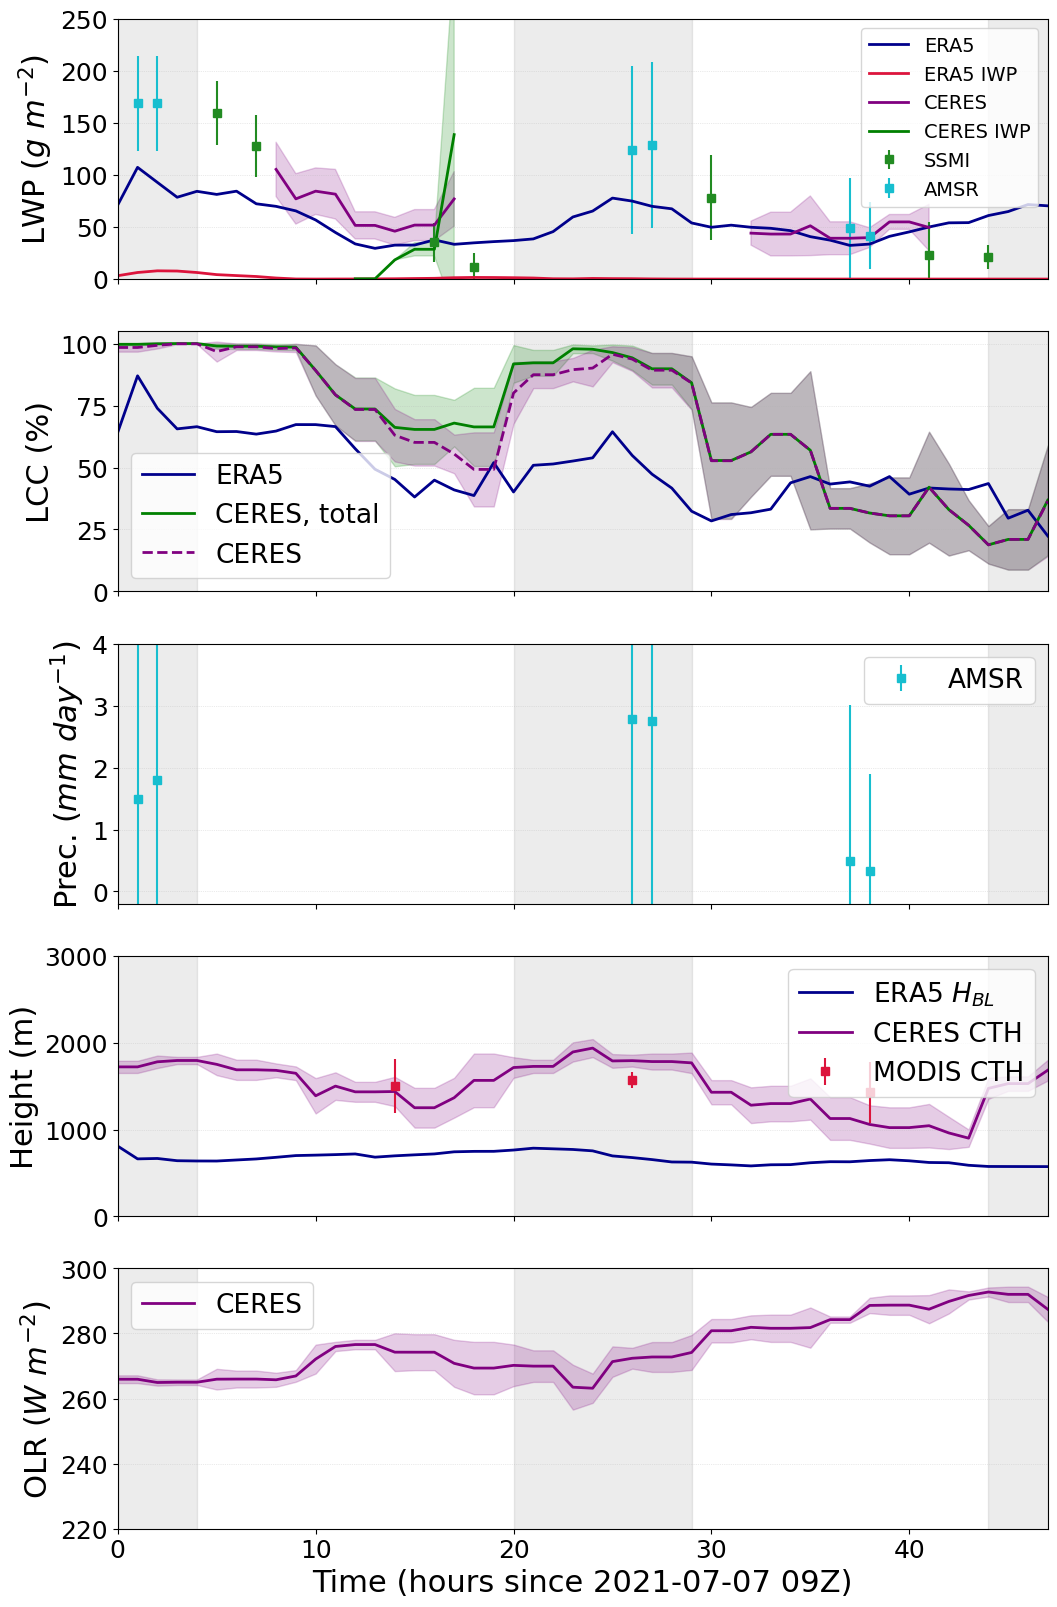

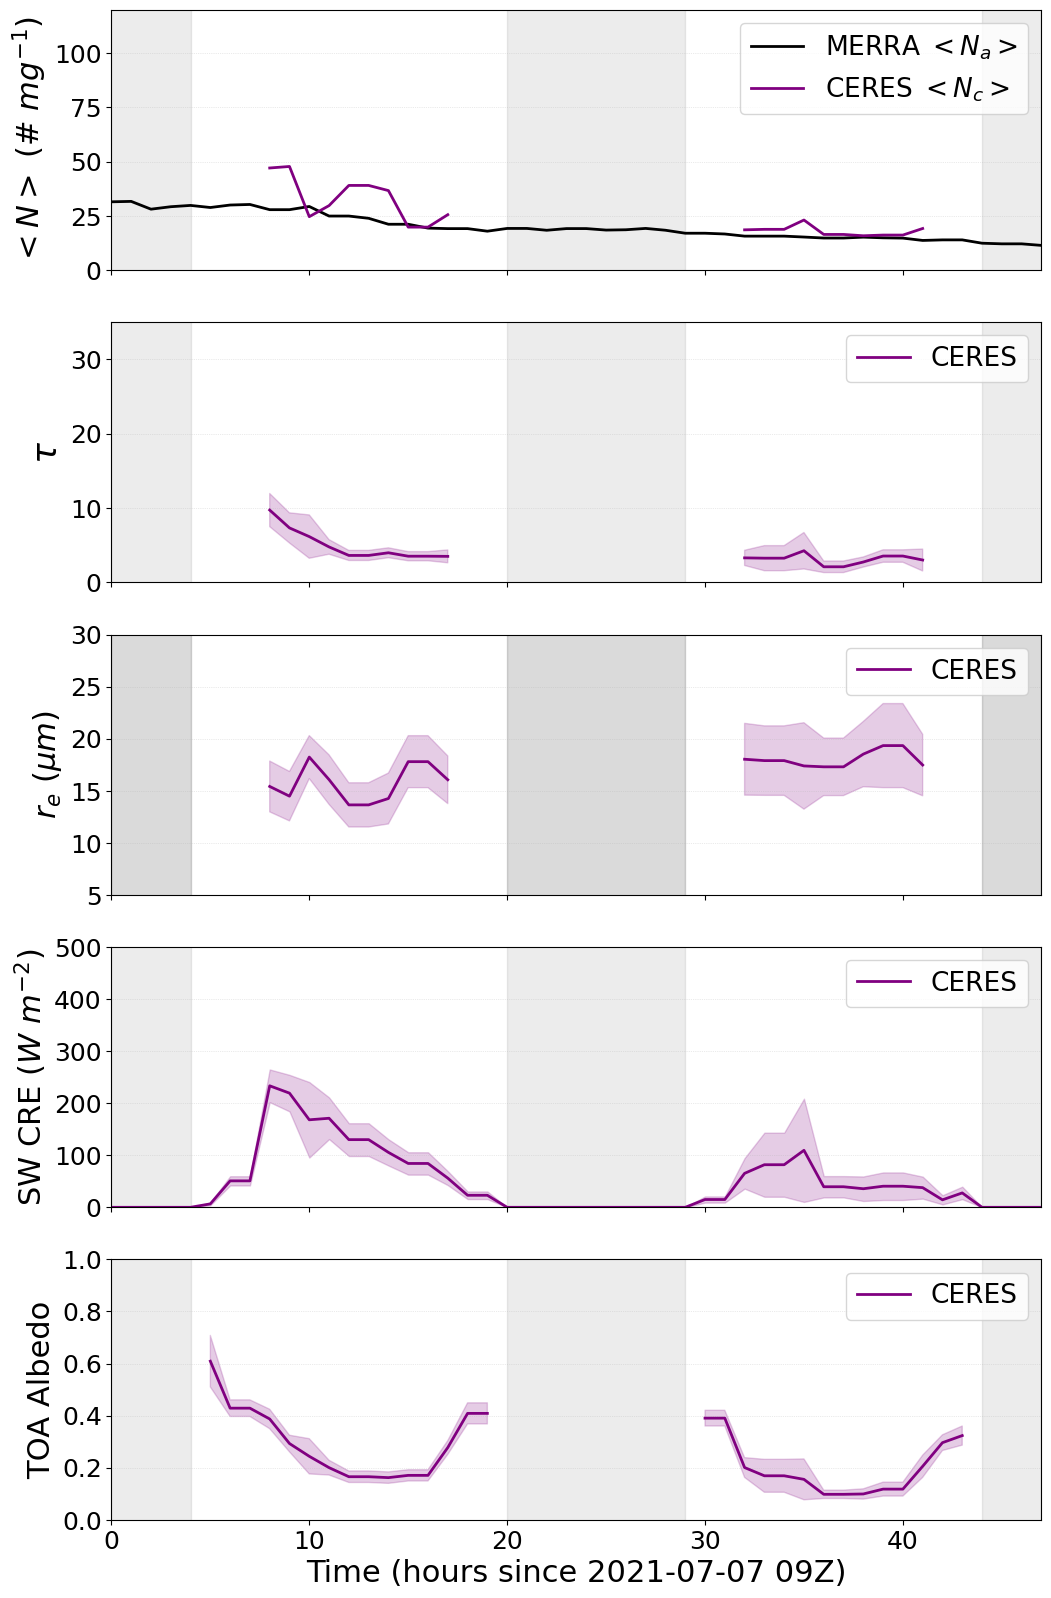

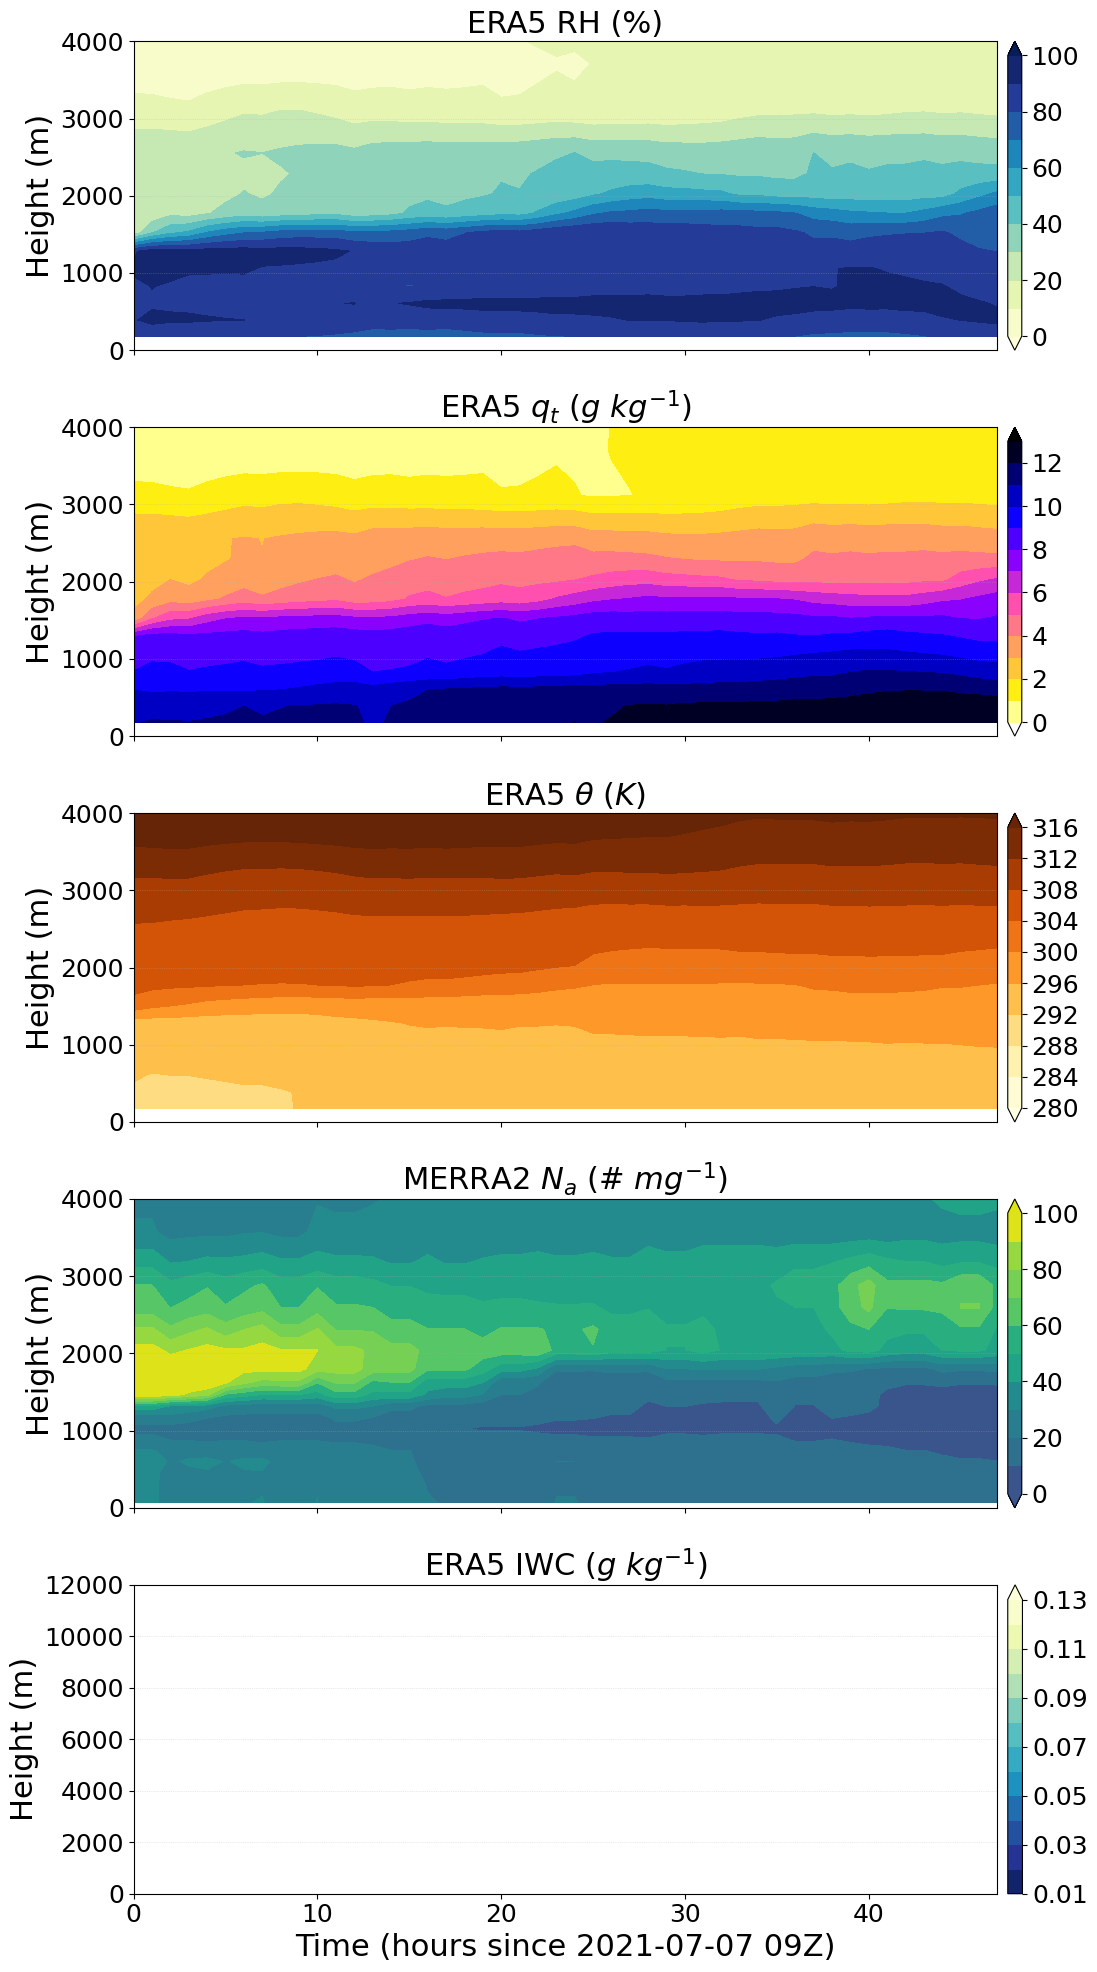

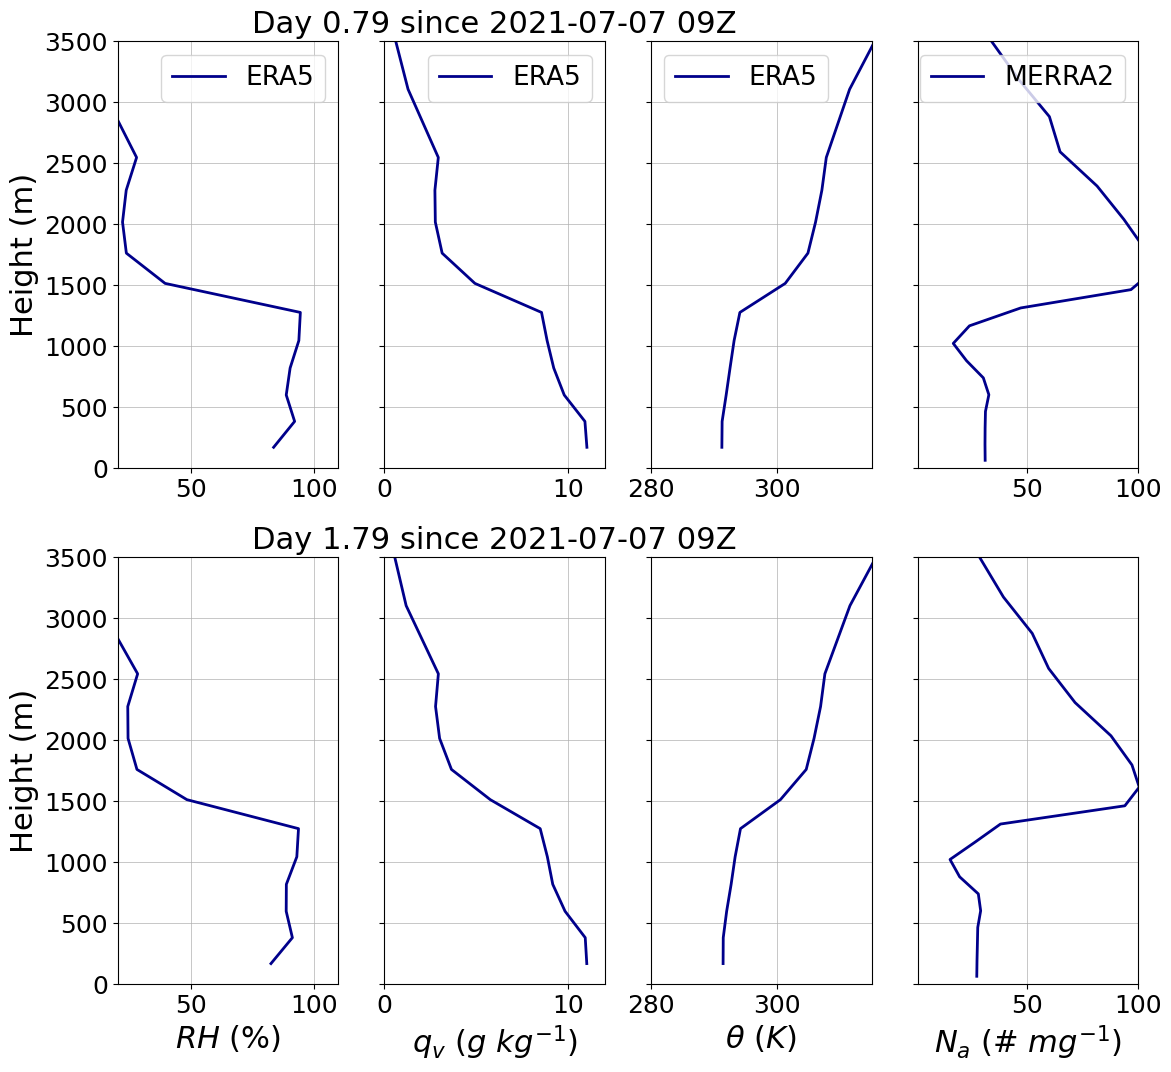

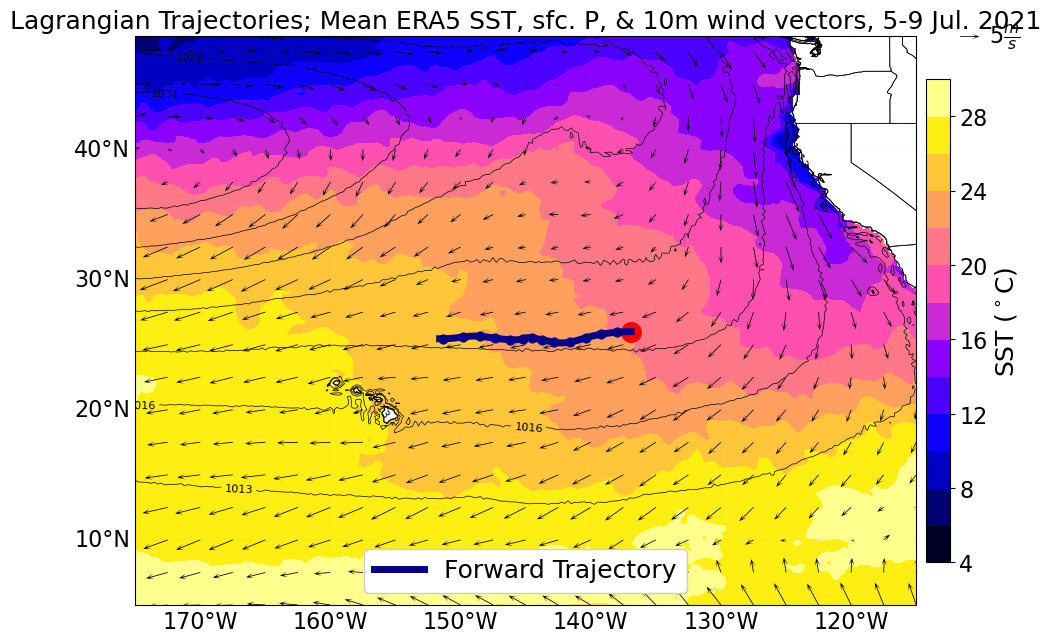

In [6]:
for traj_loc in ['05']:# traj_locs:    
    traj_postprocess(camp='NEP', dn='./', date='20210707', HH='09', t_strt='09', del_t=48, traj_dirc=['forward'], t_flight=[0.79, 1.79], Obs_jump=19)